In [4]:
!pip install xgboost

     -------------------------------------- 125.4/125.4 MB 3.2 MB/s eta 0:00:00


In [30]:
import xgboost
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')

import scipy.stats
from scipy.stats import shapiro
from scipy.stats import bartlett, levene

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [31]:
df_broadcasting = pd.read_csv("C:/Users/tomy8/POSCOOOOOOOOO/빅데이터/조별프로젝트/code/Broad_Casting.csv")
df_crewgroup = pd.read_csv("C:/Users/tomy8/POSCOOOOOOOOO/빅데이터/조별프로젝트/code/Crew_group.csv")
df_product = pd.read_csv("C:/Users/tomy8/POSCOOOOOOOOO/빅데이터/조별프로젝트/code/Product.csv")

In [32]:
# 최종 데이터셋 구축
def model_data(df1,df2,df3):
    # data 병합
    df1['방송Code'] = df2['방송Code']
    
    방송1 = df1.loc[:,['방송Code','채널','소요분','가중분','방송구분','프로그램명']]
    방송2 = df2.loc[:,['PD','SH','TD']]
    방송12 = pd.concat([방송1, 방송2], axis=1)
    
    상품1 = df1.loc[:,~df1.columns.isin(['방송Code','채널','소요분','가중분','방송구분','프로그램명'])]
    상품2 = df2.loc[:,['MD담당자명','부서코드','부서명','협력사ID','협력사명']]
    상품12 = pd.concat([상품1, 상품2], axis=1)
    df_bc = pd.concat([방송12,상품12],axis=1)
    
    제품1 = df3.loc[:,['상품ID','브랜드명','대분류','중분류','소분류','세분류','카테고리']]
    df_total = pd.merge(제품1, df_bc, how='right', on='상품ID')
    
    # 이상치 변환
    df_total = df_total.replace({'상품방송순번':63},6)
    df_total = df_total.replace({'상품방송순번':12},2)
    df_total = df_total.replace({'ARS금액':2},0)
    df_total = df_total.replace({'ARS금액':2},0) 
    df_total = df_total.replace({'카테고리':'이미용_기타'},'이미용')
    
    for i in range(len(df_total)):
        if df_total['판매단가'][i] == 0:
            df_total['판매단가'][i] = df_total['상품주문금액'][i] / df_total['상품주문수량'][i]
        
    # 필요없는 열 제거
    df_total = df_total.drop(['소분류','세분류','채널','매입과세구분','협력사명','방송종료시간'], axis=1 ,inplace=False)
    
    # 필요없는 행 제거
    nodata1 = df_total[df_total['상품명'].str.contains('사용금지')].index
    df_total.drop(nodata1, inplace=True)
    nodata2 = df_total[df_total['상품명'].str.contains('미사용')].index
    df_total.drop(nodata2, inplace=True)    
    
    # 중복 행 제거
    df_total.drop_duplicates(['방송Code'] , keep='first', inplace=True, ignore_index=False)
    
    # 파생변수 생성
    df_total['Date'] = pd.to_datetime(df_total['방송시작시간'])
    df_total['year'] = df_total['Date'].dt.year
    df_total['month'] = df_total['Date'].dt.month
    df_total['day'] = df_total['Date'].dt.day
    df_total['hour'] = df_total['Date'].dt.hour
    df_total['weekday'] = df_total['Date'].dt.weekday
    df_total['yearmonth'] = df_total['Date'].dt.year.astype(str) + df_total['Date'].dt.month.astype(str)
    df_total = df_total.replace({'yearmonth':'20201'},'202001')
    df_total = df_total.replace({'yearmonth':'20202'},'202002')
    df_total = df_total.replace({'yearmonth':'20203'},'202003')
    df_total = df_total.replace({'yearmonth':'20204'},'202004')
    df_total = df_total.replace({'yearmonth':'20205'},'202005')
    df_total = df_total.replace({'yearmonth':'20206'},'202006')
    df_total = df_total.replace({'yearmonth':'20207'},'202007')
    df_total = df_total.replace({'yearmonth':'20208'},'202008')
    df_total = df_total.replace({'yearmonth':'20209'},'202009')
    
    df_total = df_total.replace({'yearmonth':'20211'},'202101')
    df_total = df_total.replace({'yearmonth':'20212'},'202102')
    df_total = df_total.replace({'yearmonth':'20213'},'202103')
    df_total = df_total.replace({'yearmonth':'20214'},'202104')
    df_total = df_total.replace({'yearmonth':'20215'},'202105')
    df_total = df_total.replace({'yearmonth':'20216'},'202106')
    df_total = df_total.replace({'yearmonth':'20217'},'202107')
    df_total = df_total.replace({'yearmonth':'20218'},'202108')
    df_total = df_total.replace({'yearmonth':'20219'},'202109')
    
    df_total = df_total.replace({'weekday':0},'월요일')
    df_total = df_total.replace({'weekday':1},'화요일')
    df_total = df_total.replace({'weekday':2},'수요일')
    df_total = df_total.replace({'weekday':3},'목요일')
    df_total = df_total.replace({'weekday':4},'금요일')
    df_total = df_total.replace({'weekday':5},'토요일')
    df_total = df_total.replace({'weekday':6},'일요일')
    
    df_total['상품가중치'] = df_total['상품가중분'] / df_total['상품소요분']
    df_total['홈쇼핑 수수료'] = df_total['판매단가'] * (df_total['수수료율'] / 100)
    df_total['최종주문수량'] = df_total['상품주문수량'] - df_total['상품취소수량']
    df_total['매출'] = df_total['홈쇼핑 수수료'] * df_total['최종주문수량']
    
    df_total['구매의사철회율'] = (df_total['상품취소수량'] / df_total['상품주문수량']) * 100
    df_total['구매의사철회율'] = df_total['구매의사철회율'].fillna(0)
    
    bins = [0,2,5,8,11,12]
    labels = ['winter','spring','summer','autumn','winter']
    df_total['season'] =  pd.cut(df_total['month'],bins, right=True,labels=labels,ordered=False)
    df_total.reset_index(drop=True,inplace=True)
    
    목표달성 = df_total[ df_total['상품목표주문금액'] < df_total['상품주문금액'] ]
    cate = df_total.groupby('카테고리')['방송Code'].count()
    MD1 = df_total.groupby(['MD담당자명','카테고리'],as_index=False)['방송Code'].count()
    MD2 = 목표달성.groupby(['MD담당자명','카테고리'],as_index=False)['방송Code'].count()
    MD = pd.merge(MD1, MD2, how='left', on=('MD담당자명','카테고리'))
    MD.fillna(0,inplace=True)
    MD.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    MD = pd.merge(MD,cate, how='left', on=('카테고리'))
    MD.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    MD['가중치'] = MD['총 방송 건수'] / MD['카테고리 별 총 방송 건수']
    MD['MD 역량'] = (MD['목표 달성 건수'] / MD['총 방송 건수']) * 100 * MD['가중치']
    MD.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)
    SH1 = df_total.groupby(['SH','카테고리'],as_index=False)['방송Code'].count()
    SH2 = 목표달성.groupby(['SH','카테고리'],as_index=False)['방송Code'].count()
    SH = pd.merge(SH1, SH2, how='left', on=('SH','카테고리'))
    SH.fillna(0,inplace=True)
    SH.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    SH = pd.merge(SH,cate, how='left', on=('카테고리'))
    SH.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    SH['가중치'] = SH['총 방송 건수'] / SH['카테고리 별 총 방송 건수']
    SH['SH 역량'] = (SH['목표 달성 건수'] / SH['총 방송 건수']) * 100  * SH['가중치']
    SH.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)
    PD1 = df_total.groupby(['PD','카테고리'],as_index=False)['방송Code'].count()
    PD2 = 목표달성.groupby(['PD','카테고리'],as_index=False)['방송Code'].count()
    PD = pd.merge(PD1, PD2, how='left', on=('PD','카테고리'))
    PD.fillna(0,inplace=True)
    PD.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    PD = pd.merge(PD,cate, how='left', on=('카테고리'))
    PD.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    PD['가중치'] = PD['총 방송 건수'] / PD['카테고리 별 총 방송 건수']
    PD['PD 역량'] = (PD['목표 달성 건수'] / PD['총 방송 건수']) * 100  * PD['가중치']
    PD.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)    
    TD1 = df_total.groupby(['TD','카테고리'],as_index=False)['방송Code'].count()
    TD2 = 목표달성.groupby(['TD','카테고리'],as_index=False)['방송Code'].count()
    TD = pd.merge(TD1, TD2, how='left', on=('TD','카테고리'))
    TD.fillna(0,inplace=True)
    TD.rename(columns={'방송Code_x':'총 방송 건수','방송Code_y':'목표 달성 건수'},inplace=True)
    TD = pd.merge(TD,cate, how='left', on=('카테고리'))
    TD.rename(columns={'방송Code':'카테고리 별 총 방송 건수'},inplace=True)
    TD['가중치'] = TD['총 방송 건수'] / TD['카테고리 별 총 방송 건수']
    TD['TD 역량'] = (TD['목표 달성 건수'] / TD['총 방송 건수']) * 100 * TD['가중치']
    TD.drop(['총 방송 건수','목표 달성 건수','카테고리 별 총 방송 건수','가중치'],axis=1, inplace=True)    
    df_total = pd.merge(df_total,PD, how='left',on=('PD','카테고리'))
    df_total = pd.merge(df_total,SH, how='left',on=('SH','카테고리'))
    df_total = pd.merge(df_total,TD, how='left',on=('TD','카테고리'))
    df_total = pd.merge(df_total,MD, how='left',on=('MD담당자명','카테고리'))
    df_total['제작진역량'] = df_total['PD 역량']*0.3 + df_total['SH 역량']*0.3 + df_total['TD 역량']*0.1 + df_total['MD 역량']*0.3
    
    df_total['month'] = df_total['month'].astype(str)
    df_total['hour'] = df_total['hour'].astype(str)
    df_total['season'] = df_total['season'].astype(str)
    
    df_total = df_total.fillna(0)
    final_df = df_total
    return final_df
    

In [33]:
df_raw = model_data(df_broadcasting, df_crewgroup, df_product)

- 카테고리 별로 데이터셋 구성
- y : 최종주문수량
- x : 판매단가, 수수료율, ARS금액, 매입형태, 배송방식, 상품방송순번, month, hour, weekday, season, PD 역량, SH 역량, TD 역량, MD역량

In [34]:
# 생방송만
df = df_raw[df_raw['방송구분'] == '생방송']

In [35]:
df = df[['카테고리','최종주문수량','판매단가','매입형태','배송방식','month','hour','weekday','PD 역량','SH 역량','TD 역량','MD 역량']]

In [36]:
df_의류 = df[df['카테고리'] == '의류']
df_신선농산 = df[df['카테고리'] == '신선농산']
df_생활용품 = df[df['카테고리'] == '생활용품']
df_건강식품 = df[df['카테고리'] == '건강식품']
df_인테리어 = df[df['카테고리'] == '인테리어']
df_침구 = df[df['카테고리'] == '침구']
df_신선수산 = df[df['카테고리'] == '신선수산']
df_잡화 = df[df['카테고리'] == '잡화']
df_가공농산 = df[df['카테고리'] == '가공농산']
df_주방용품 = df[df['카테고리'] == '주방용품']
df_가공축산 = df[df['카테고리'] == '가공축산']
df_이미용 = df[df['카테고리'] == '이미용']
df_가전 = df[df['카테고리'] == '가전']
df_가공수산 = df[df['카테고리'] == '가공수산']
df_보석 = df[df['카테고리'] == '보석']
df_상생_식품 = df[df['카테고리'] == '상생_식품']
df_레포츠기기 = df[df['카테고리'] == '레포츠기기']
df_언더웨어 = df[df['카테고리'] == '언더웨어']
df_신선축산 = df[df['카테고리'] == '신선축산']
df_문화서비스 = df[df['카테고리'] == '문화서비스']
df_상생_공산품 = df[df['카테고리'] == '상생_공산품']
df_레포츠의류 = df[df['카테고리'] == '레포츠의류']
df_상조 = df[df['카테고리'] == '상조']

In [37]:
# 더미 만들고
# 전처리하고 MinMaxScaler
# Y , X 데이터 나누고
# train_test_split

# Decisition tree, random forest, gradient boosting , xgboost
# accuracy 높은 모델 선정
# 최종 카테고리별 수요예측모델 생성

array([[<AxesSubplot:title={'center':'최종주문수량'}>,
        <AxesSubplot:title={'center':'판매단가'}>],
       [<AxesSubplot:title={'center':'PD 역량'}>,
        <AxesSubplot:title={'center':'SH 역량'}>],
       [<AxesSubplot:title={'center':'TD 역량'}>,
        <AxesSubplot:title={'center':'MD 역량'}>]], dtype=object)

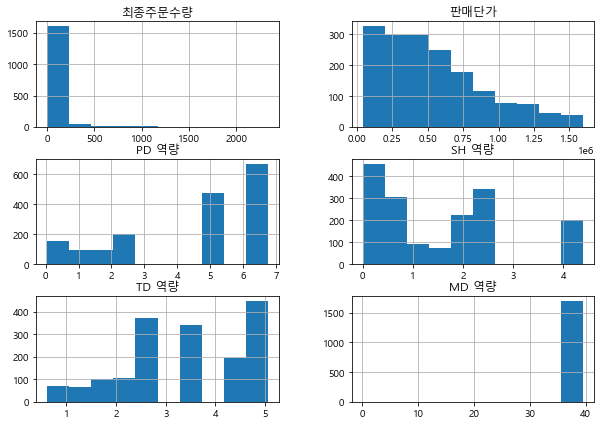

In [38]:
df_인테리어.hist(figsize=(10,7))

In [39]:
df_인테리어['최종주문수량'] = np.log1p(df_인테리어['최종주문수량'])
df_인테리어['판매단가'] = np.log1p(df_인테리어['판매단가'])
df_인테리어['PD 역량'] = np.log1p(df_인테리어['PD 역량'])
df_인테리어['SH 역량'] = np.log1p(df_인테리어['SH 역량'])
df_인테리어['TD 역량'] = np.log1p(df_인테리어['TD 역량'])
df_인테리어['MD 역량'] = np.log1p(df_인테리어['MD 역량'])

array([[<AxesSubplot:title={'center':'최종주문수량'}>,
        <AxesSubplot:title={'center':'판매단가'}>],
       [<AxesSubplot:title={'center':'PD 역량'}>,
        <AxesSubplot:title={'center':'SH 역량'}>],
       [<AxesSubplot:title={'center':'TD 역량'}>,
        <AxesSubplot:title={'center':'MD 역량'}>]], dtype=object)

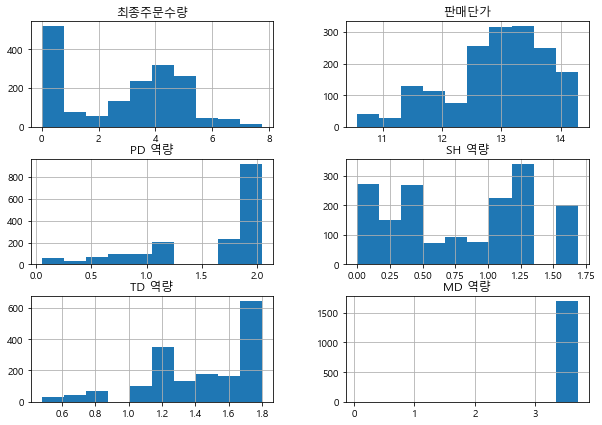

In [40]:
df_인테리어.hist(figsize=(10,7))

In [41]:
def modeling_set(x):
    x = x.drop('카테고리',axis=1, inplace=False)
    x_dummy = pd.get_dummies(x) 
    
    df_x = x_dummy.drop('최종주문수량', axis=1, inplace=False)
    df_y = x_dummy['최종주문수량']
    
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(df_x)
    x_scaled = pd.DataFrame(x_scaled, columns = df_x.columns)
    
    df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(x_scaled, df_y,
                                                               test_size=0.3 , random_state = 1234)
    
    return df_train_x, df_test_x, df_train_y, df_test_y

In [42]:
df_train_x, df_test_x, df_train_y, df_test_y = modeling_set(df_인테리어)

In [96]:
estimator = DecisionTreeRegressor()
para_depth = [depth for depth in range(1,10)]
para_split = [split  for split in range(1,10)]
para_leaf = [leaf for leaf in range(1,10)]
param_grid = {'criterion' : ['mse','friedman_mse','mae'],'max_features':['auto','sqrt','log2'],
             'max_depth':para_depth,'min_samples_split':para_split,
             'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator,param_grid,scoring='r2',n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print('best estimator model : \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nnbest score : \n{}'.format(grid_dt.best_score_.round(3)))

KeyboardInterrupt: 

In [25]:
df_tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=7, min_samples_split=5, max_depth=8)
df_tree.fit(df_train_x, df_train_y)

print('train data의 정확도:', df_tree.score(df_train_x,df_train_y))
print('test data의 정확도:', df_tree.score(df_test_x,df_test_y))

train data의 결정계수: 0.5260108596329603
test data의 결정계수: 0.41532848745670525


# ============================================

In [116]:
estimator = RFR(random_state =1234)
para_depth = [depth for depth in range(1,10)]
para_split = [split  for split in range(2,10)]
para_leaf = [leaf for leaf in range(1,10)]
param_grid ={'max_depth':para_depth,'min_samples_split':para_split,
             'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator,param_grid,scoring='r2',n_jobs = -1,refit = True)
grid_dt.fit(df_train_x, df_train_y)

print('best estimator model : \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nnbest score : \n{}'.format(grid_dt.best_score_.round(3)))


NameError: name 'best_estimator_' is not defined

In [114]:
rf_tree = RFR(random_state=1234, min_samples_leaf=1, min_samples_split=4, max_depth=9, n_estimators = 100)
rf_tree.fit(df_train_x, df_train_y)

print('train data의 정확도:', rf_tree.score(df_train_x,df_train_y))
print('test data의 정확도:', rf_tree.score(df_test_x,df_test_y))

train data의 정확도: 0.7007773302282181
test data의 정확도: 0.4659778171503778


# ===========================================

In [53]:
# train 및 test 설명력 결과 저장
train_score = [] ;test_score = []
    
# n_estimatos : 트리 수 변경(10~100) * para_n_tree: [10, 20, ..., 100]
para_n_tree = [n_tree for n_tree in range(300,500)]

for v_n_estimators in para_n_tree:
    gb=GBR(n_estimators = v_n_estimators, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
total_score_n = pd.DataFrame()
total_score_n['Estimators'] = para_n_tree
total_score_n['TrainScore'] = train_score
total_score_n['TestScore'] = test_score

total_score_n.round(3)

,Estimators,TrainScore,TestScore
0,300,0.793,0.420
1,301,0.793,0.422
2,302,0.794,0.423
3,303,0.794,0.422
4,304,0.795,0.422
...,...,...,...
195,495,0.858,0.398
196,496,0.858,0.398
197,497,0.858,0.399
198,498,0.858,0.400


In [57]:
train_score = [] ; test_score = []

# min_samples_leaf : 잎사귀 최소 자료 수 ** para_leaf : [1, 2, 3, ..., 20]
para_leaf = [n_leaf * 1 for n_leaf in range(1, 30)]

for v_min_samples_leaf in para_leaf:
    gb=GBR(random_state=1234, n_estimators = 200, 
           min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
total_score_leaf = pd.DataFrame()
total_score_leaf['MinSamplesLeaf'] = para_leaf
total_score_leaf['TrainScore']=train_score
total_score_leaf['TestScore'] = test_score
total_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.736,0.470
1,2,0.729,0.493
2,3,0.725,0.482
3,4,0.709,0.501
4,5,0.707,0.501
5,6,0.702,0.478
6,7,0.701,0.491
7,8,0.688,0.504
8,9,0.684,0.507
9,10,0.683,0.506


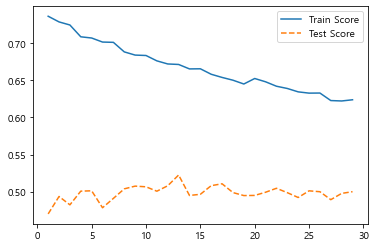

In [58]:
plt.plot(para_leaf, train_score, linestyle='-', label='Train Score')
plt.plot(para_leaf, test_score, linestyle='--', label='Test Score')
plt.legend();

In [61]:
train_score = [] ;test_score = []
    
# min_samples_split : 분할하기 위한 노드의 최소 자료 수 * 참조:para_split:[2, 4, 6, ..., 40]
para_split = [n_split for n_split in range(2,21)]

for v_min_samples_split in para_split:
    gb=GBR(random_state=1234, n_estimators = 200 ,min_samples_leaf = 2,
                             min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
total_score_split = pd.DataFrame()
total_score_split['MinSamplesSplit'] = para_split
total_score_split['TrainScore'] = train_score
total_score_split['TestScore'] = test_score
total_score_split.round(3)
# 모델 설명력 확인

,MinSamplesSplit,TrainScore,TestScore
0,2,0.729,0.493
1,3,0.729,0.493
2,4,0.729,0.493
3,5,0.735,0.488
4,6,0.722,0.495
5,7,0.726,0.500
6,8,0.719,0.493
7,9,0.721,0.492
8,10,0.722,0.500
9,11,0.717,0.503


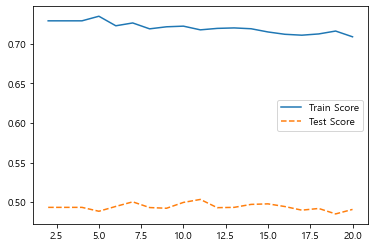

In [62]:
plt.plot(para_split, train_score, linestyle='-', label='Train Score')
plt.plot(para_split, test_score, linestyle='--', label='Test Score')
plt.legend();

In [63]:
train_score = [] ;test_score = []
    
# min_samples_split : 분할하기 위한 노드의 최소 자료 수 * 참조:para_split:[2, 4, 6, ..., 40]
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb=GBR(random_state=1234,n_estimators = 200,min_samples_leaf = 2,
           min_samples_split=7, max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
total_score_depth = pd.DataFrame()
total_score_depth['Depth'] = para_depth
total_score_depth['TrainScore'] = train_score
total_score_depth['TestScore'] = test_score

# 모델 설명력 확인
total_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.458,0.457
1,2,0.603,0.509
2,3,0.726,0.500
3,4,0.840,0.468
4,5,0.914,0.446
5,6,0.962,0.418
6,7,0.989,0.424
7,8,0.996,0.445
8,9,0.998,0.444
9,10,1.000,0.415


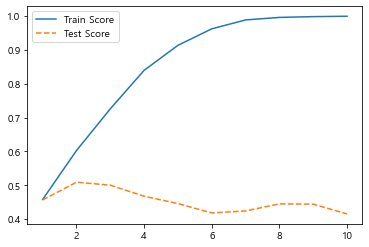

In [64]:
plt.plot(para_depth, train_score, linestyle='-', label='Train Score')
plt.plot(para_depth, test_score, linestyle='--', label='Test Score')
plt.legend();

In [65]:
train_score = [] ; test_score = []

# learning rate: 학습률 변경 0.1~0.9 ** para_lr : [0.1, 0.2, ..., 0.9]
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb=GBR(random_state=1234, n_estimators = 200, min_samples_leaf= 2, min_samples_split = 7,
                                 max_depth = 9, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
total_score_lr = pd.DataFrame()
total_score_lr['LearningRate'] = para_lr
total_score_lr['TrainScore']=train_score
total_score_lr['TestScore'] = test_score

total_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.998,0.444
1,0.2,1.000,0.444
2,0.3,1.000,0.359
3,0.4,1.000,0.378
4,0.5,1.000,0.308
5,0.6,1.000,0.299
6,0.7,1.000,0.260
7,0.8,1.000,0.231
8,0.9,1.000,0.172


In [77]:
gb_tree = GBR(random_state=1234, min_samples_leaf=1, min_samples_split=2, max_depth=7, n_estimators = 1000, learning_rate=0.2)
gb_tree.fit(df_train_x, df_train_y)

print('train data의 정확도:', gb_tree.score(df_train_x,df_train_y))
print('test data의 정확도:', gb_tree.score(df_test_x,df_test_y))

train data의 정확도: 0.9998906787498705
test data의 정확도: 0.40624537997367705


In [32]:
# estimator = GBR(random_state =1234)
# para_depth = [depth for depth in range(1,10)]
# para_split = [split for split in range(2,10)]
# para_leaf = [leaf for leaf in range(1,10)]
# para_lr = [lr * 0.1 for lr in range(1, 10)]
# param_grid ={'max_depth':para_depth,'min_samples_split':para_split,
#              'min_samples_leaf':para_leaf, 'learning_rate' : para_lr}

# grid_dt = GridSearchCV(estimator,param_grid,scoring='r2',n_jobs = -1)
# grid_dt.fit(df_train_x, df_train_y)

# print('best estimator model : \n{}'.format(grid_dt.best_estimator_))
# print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
# print('\nnbest score : \n{}'.format(grid_dt.best_score_.round(3)))

best estimator model : 
GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=3,
                          min_samples_split=7, random_state=1234)

best parameter: 
{'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 7}

nbest score : 
0.468


In [33]:
gb_tree = GBR(random_state=1234, min_samples_leaf=3, min_samples_split=7, max_depth=3, n_estimators = 100, learning_rate=0.2)
gb_tree.fit(df_train_x, df_train_y)

print('train data의 정확도:', gb_tree.score(df_train_x,df_train_y))
print('test data의 정확도:', gb_tree.score(df_test_x,df_test_y))

train data의 정확도: 0.7176295527467642
test data의 정확도: 0.47305895252453656


# ============================================

In [43]:
estimator = XGBRegressor(random_state =1234)
para_depth = [depth for depth in range(1,10)]
para_lr = [lr * 0.1 for lr in range(2, 10)]

param_grid ={'criterion' : ['mse','friedman_mse','mae'],'max_features':['auto','sqrt','log2'],
             'max_depth':para_depth, 'learning_rate': para_lr}

grid_dt = GridSearchCV(estimator,param_grid,scoring='r2',n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print('best estimator model : \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nnbest score : \n{}'.format(grid_dt.best_score_.round(3)))

[01:07:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


best estimator model : 
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             criterion='mse', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.4, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_features='auto', max_leaves=0, min_child_weight=1, miss

In [53]:
xgb_tree = XGBRegressor(random_state=1234, max_depth=5, n_estimators = 100, learning_rate=0.3)
xgb_tree.fit(df_train_x, df_train_y)

print('train data의 정확도:', xgb_tree.score(df_train_x,df_train_y))
print('test data의 정확도:', xgb_tree.score(df_test_x,df_test_y))

train data의 정확도: 0.9786599404489256
test data의 정확도: 0.6959846454093634


### 이정도 정확도가 제 한계입니다만. depth가 1인건 비밀입니다.
### 좋습니다.